# Titanic (lightGBM classifier)
* Notebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/titanic_lightgbm.ipynb
* kaggle: https://www.kaggle.com/c/titanic
* lightgbm: https://lightgbm.readthedocs.io/en/latest/

[<img src="https://github.com/microsoft/LightGBM/raw/master/docs/logo/LightGBM_logo_black_text_small.png">](https://lightgbm.readthedocs.io/en/latest/)

---
* author:  [Prasert Kanawattanachai](prasert.k@chula.ac.th)
* YouTube: https://www.youtube.com/prasertcbs
* github: https://github.com/prasertcbs/
* [Chulalongkorn Business School](https://www.cbs.chula.ac.th/en/)
---

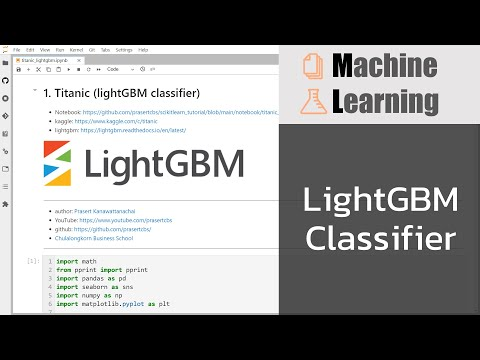

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Bdy_3Mppl8s', width=720, height=405)

In [2]:
import math
from pprint import pprint
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pandas  version: 1.2.3
numpy   version: 1.19.2
seaborn version: 0.11.1


## utility functions

In [5]:
def df_unique_value(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            print(f'{c:10}\n{df[c].unique()}')
            print('-' * 65)
            
def convert_cols_to_category(df, cols:list):
    """
    convert `cols` to `category`
    """
    for c in df[cols]:
        df[c] = df[c].astype('category')
    return df
    
def convert_obj_columns_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return df

def print_category_columns(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type.name == 'category':
    #         print(f'{c}: {df[c].cat.categories}')
    #         print(pd.Series(df[c].cat.categories))
            print(f'{c:15}: {list(enumerate(df[c].cat.categories))}')
            print('-' * 60)
            
def plot_mn(df, cols, n_rows:int=1, kind:str='boxplot', color='salmon'):
    """
    plot boxplot, violin, hist in m (rows) by n (columns)
    >>> plot_mn(df, ['Calories', 'Fat'], 2, 'hist')
    """
    n=len(cols)
    n_cols=math.ceil(n / n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*4))
    ax=ax.ravel()

    fig.tight_layout()
    for i, c in enumerate(cols):
        col_type = df[c].dtype
        if col_type.name == 'category':
            sns.countplot(data=df, x=c, ax=ax[i])
        else:
            if kind.lower()=='boxplot':
                sns.boxplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='violin':
                sns.violinplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='hist':
                sns.distplot(df[c], hist=True, kde=False, ax=ax[i], color=color)  


## data
| Variable | Definition                                                             | Key                                            |
|----------|------------------------------------------------------------------------|------------------------------------------------|
| Survived | Survival                                                               | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                                                           | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                                                    |                                                |
| Age      | Age in years                                                           |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic                             |                                                |
|          | Sibling = brother, sister, stepbrother, stepsister                     |                                                |
|          | Spouse = husband, wife (mistresses and fiancés were ignored)           |                                                |
| Parch    | # of parents / children aboard the Titanic                             |                                                |
|          | Parent = mother, father                                                |                                                |
|          | Child = daughter, son, stepdaughter, stepson                           |                                                |
|          | Some children travelled only with a nanny, therefore parch=0 for them. |                                                |
| Ticket   | Ticket number                                                          |                                                |
| Fare     | Passenger fare                                                         |                                                |
| Cabin    | Cabin number                                                           |                                                |
| Embarked | Port of Embarkation                                                    | C = Cherbourg, Q = Queenstown, S = Southampton |

In [6]:
df=pd.read_csv('https://github.com/prasertcbs/basic-dataset/raw/master/titanic_train.csv')
df.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
107,108,1,3,"Moss, Mr. Albert Johan",male,NaN,0,0,312991,7.7750,NaN,S
394,395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S
609,610,1,1,"Shutes, Miss. Elizabeth W",female,40.0,0,0,PC 17582,153.4625,C125,S
485,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
172,173,1,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S
619,620,0,2,"Gavey, Mr. Lawrence",male,26.0,0,0,31028,10.5000,NaN,S
165,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.0,0,2,363291,20.5250,NaN,S
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S
16,17,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
366,367,1,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.2500,D37,C


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### convert obj/string columns to category data type for lightGBM

In [8]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
cols_to_cat=['Pclass', 'Sex', 'Embarked']

convert_cols_to_category(df, cols_to_cat)
print_category_columns(df)

Pclass         : [(0, 1), (1, 2), (2, 3)]
------------------------------------------------------------
Sex            : [(0, 'female'), (1, 'male')]
------------------------------------------------------------
Embarked       : [(0, 'C'), (1, 'Q'), (2, 'S')]
------------------------------------------------------------


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.8+ KB


In [11]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

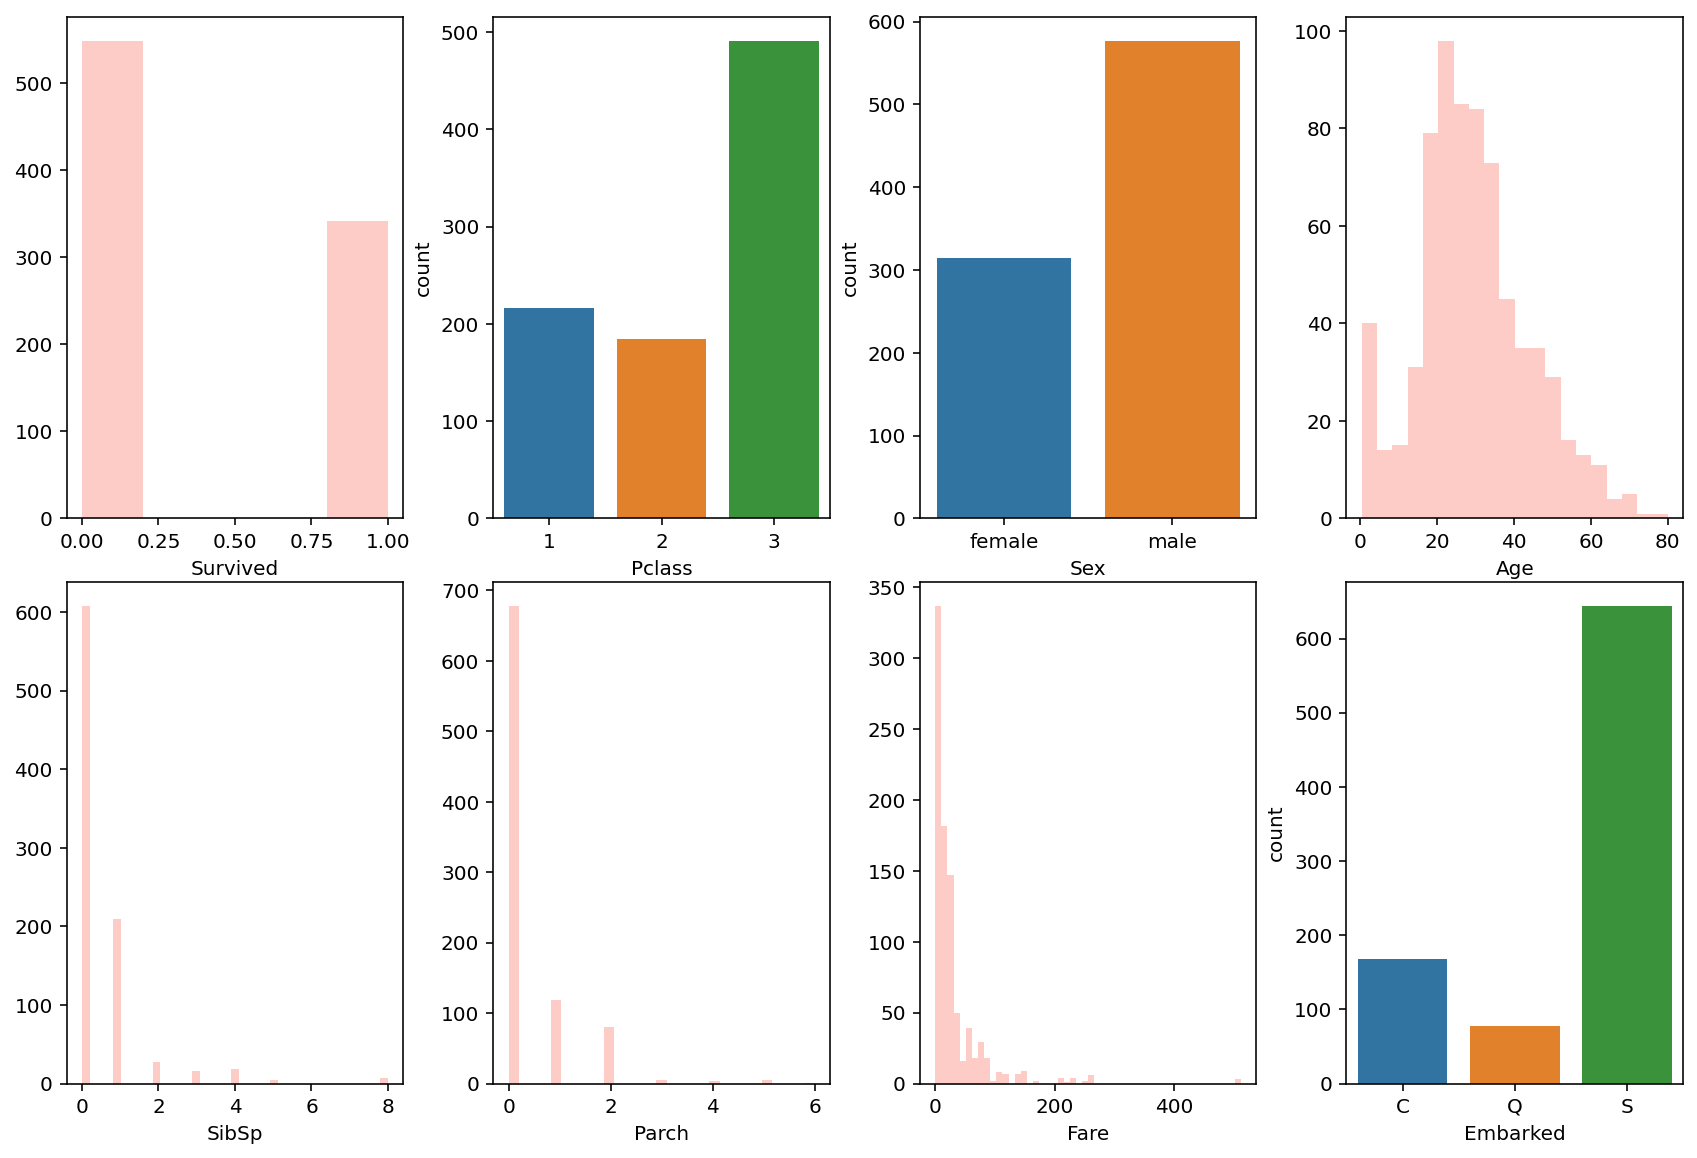

In [12]:
cols=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']
plot_mn(df, cols, 2, 'hist')

## lightgbm
* `lightGBM` doc: https://lightgbm.readthedocs.io/en/latest/
* `LGBMClassifier`: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier


how to install lightgbm
* pip: `pip install -U lightgbm`
* conda: `conda install lightgbm`

In [13]:
import lightgbm as lgb
print(f'lightgbm version {lgb.__version__}')

lightgbm version 3.1.1


In [14]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, cross_val_score, cross_val_predict, cross_validate
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score

In [15]:
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [17]:
feature_cols=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']
target_col='Survived'

X=df[feature_cols]
y=df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=1, 
                                                    stratify=y)

In [18]:
y_train.value_counts()

0    439
1    273
Name: Survived, dtype: int64

In [19]:
clf=lgb.LGBMClassifier()

In [20]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [21]:
# tuning parameters: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# https://sites.google.com/view/lauraepp/parameters
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

clf = lgb.LGBMClassifier(**params)

In [22]:
# eval_metric: https://lightgbm.readthedocs.io/en/latest/Parameters.html?highlight=metric#metric-parameters
fit_params={'early_stopping_rounds':100, 
            'eval_metric': 'auc', # [binary_logloss, auc]
            'eval_set': [(X_test, y_test)],
            'verbose': 1
           }

clf.fit(X_train, y_train, **fit_params)

[1]	valid_0's auc: 0.851647	valid_0's binary_logloss: 0.623199
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.85303	valid_0's binary_logloss: 0.588994
[3]	valid_0's auc: 0.861067	valid_0's binary_logloss: 0.559292
[4]	valid_0's auc: 0.858696	valid_0's binary_logloss: 0.538124
[5]	valid_0's auc: 0.863966	valid_0's binary_logloss: 0.516363
[6]	valid_0's auc: 0.86166	valid_0's binary_logloss: 0.501679
[7]	valid_0's auc: 0.860343	valid_0's binary_logloss: 0.489568
[8]	valid_0's auc: 0.857839	valid_0's binary_logloss: 0.479743
[9]	valid_0's auc: 0.855731	valid_0's binary_logloss: 0.469486
[10]	valid_0's auc: 0.858893	valid_0's binary_logloss: 0.460133
[11]	valid_0's auc: 0.860474	valid_0's binary_logloss: 0.451792
[12]	valid_0's auc: 0.862978	valid_0's binary_logloss: 0.443383
[13]	valid_0's auc: 0.861331	valid_0's binary_logloss: 0.439304
[14]	valid_0's auc: 0.866798	valid_0's binary_logloss: 0.433218
[15]	valid_0's auc: 0.868775	valid_0's binary_logloss

LGBMClassifier()

In [23]:
clf.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': -1,
 'silent': True,
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x1e73b6e6ac8>,
 '_evals_result': {'valid_0': OrderedDict([('auc',
                [0.8516469038208169,
                 0.853030303030303,
                 0.8610671936758894,
                 0.8586956521739131,
                 0.863965744400527,
                 0.8616600790513834,
                 0.8603425559947299,
                 0.8578392621870883,
                 0.8557312252964426,
                 0.8588932806324111,
                 0.8604743083003953,
                 0.8629776021080369,
                 0.861330

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

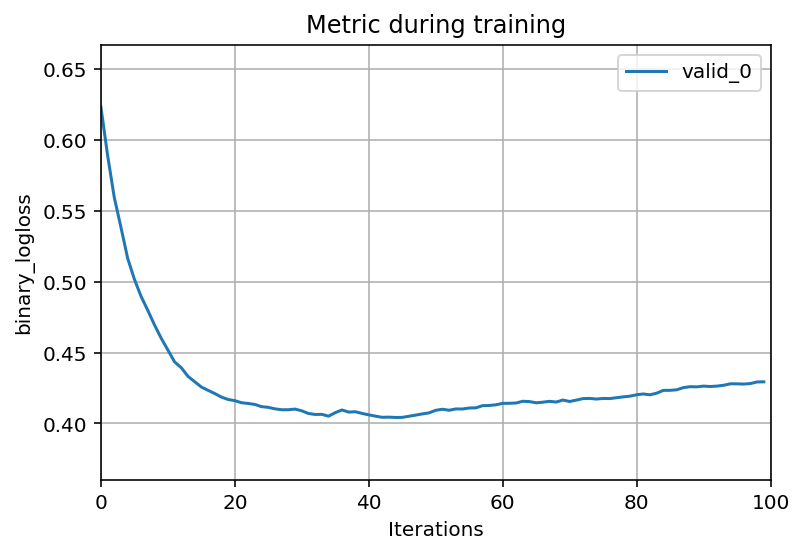

In [24]:
lgb.plot_metric(clf, metric='binary_logloss')

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

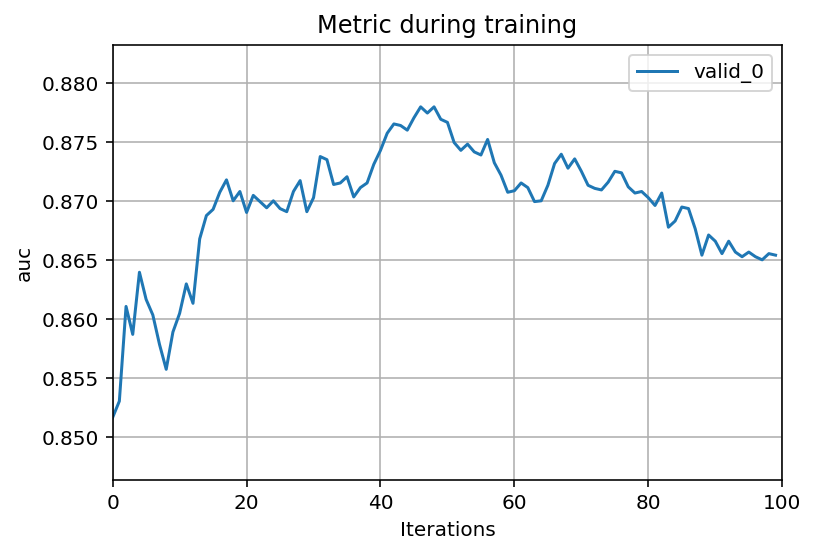

In [25]:
lgb.plot_metric(clf, metric='auc')

In [26]:
clf.score(X_train, y_train) # classification accuracy score

0.875

In [27]:
clf.score(X_test, y_test) # classification accuracy score

0.8324022346368715

In [28]:
clf.predict(X_test)[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
      dtype=int64)

In [29]:
clf.predict_proba(X_test)[:20]

array([[0.89537663, 0.10462337],
       [0.78410519, 0.21589481],
       [0.81092477, 0.18907523],
       [0.97401508, 0.02598492],
       [0.92969964, 0.07030036],
       [0.9082477 , 0.0917523 ],
       [0.79099565, 0.20900435],
       [0.80404351, 0.19595649],
       [0.9785188 , 0.0214812 ],
       [0.89752555, 0.10247445],
       [0.06506747, 0.93493253],
       [0.80404351, 0.19595649],
       [0.65860499, 0.34139501],
       [0.92953919, 0.07046081],
       [0.0223667 , 0.9776333 ],
       [0.74578894, 0.25421106],
       [0.94612706, 0.05387294],
       [0.18319952, 0.81680048],
       [0.42625979, 0.57374021],
       [0.9785188 , 0.0214812 ]])

### confusion matrix
$$
\begin{bmatrix}
C_{0,0} & C_{0,1} \\
C_{1,0} & C_{1,1}
\end{bmatrix}
=
\begin{bmatrix}
tn&fp \\
fn&tp
\end{bmatrix}
$$

<table>
<tr>
    <td></td>
    <td>predicted false</td>
    <td>predicted true</td>
</tr>
<tr>
    <td>actual false</td>
    <td>tn</td>
    <td>fp</td>
</tr>
<tr>
    <td>actual true</td>
    <td>fn</td>
    <td>tp</td>
</tr>
<table>

In [30]:
cm=confusion_matrix(y_test, clf.predict(X_test))
cm

array([[97, 13],
       [17, 52]], dtype=int64)

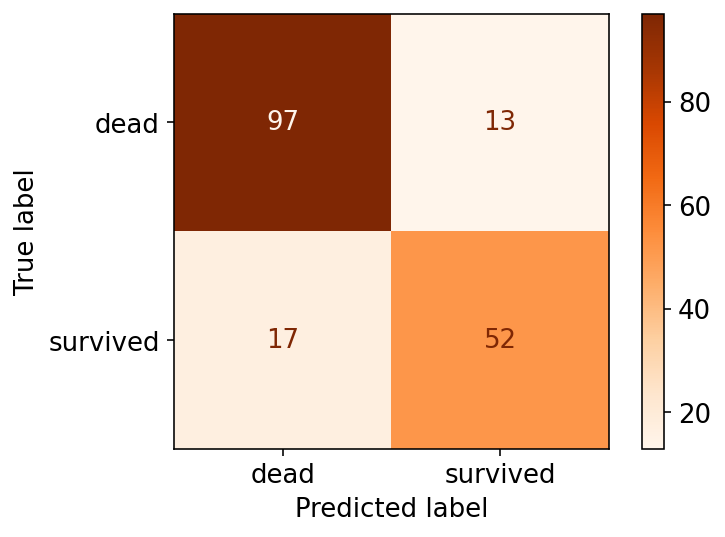

In [31]:
plt.rcParams['font.size']=13
plot_confusion_matrix(clf, X_test, y_test, cmap='Oranges', display_labels=['dead', 'survived']);

$$
\begin{align}
\text {Accuracy}&={\frac {{TP+TN} }{TP + TN +FP + FN} }\\
\text {Precision}&={\frac {TP}{TP+FP}}\\
\text {Recall, True Positive Rate (TPR), sensitivity}&={\frac {TP}{TP+FN}}\\
\text {False Positive Rate (FPR), miss rate}&={\frac {FP}{FP+TN}}\\
F1&=2 \times {\frac {precision \times recall} {precision + recall}}\\
\end{align}
$$

$$
\begin{align}
Recall_0&={\frac {TN}{TN+FP}}\\
Recall_1&={\frac {TP}{TP+FN}}\\
Precision_0&={\frac {TN}{TN+FN}}\\
Precision_1&={\frac {TP}{TP+FP}}\\
\end{align}
$$

In [32]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       439
           1       0.87      0.79      0.83       273

    accuracy                           0.88       712
   macro avg       0.87      0.86      0.87       712
weighted avg       0.87      0.88      0.87       712



In [33]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       110
           1       0.80      0.75      0.78        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

